In [1]:
from keras import backend as K
from keras.applications import vgg16
from keras.layers import Input, merge
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dense, Dropout, Flatten, Lambda
from keras.models import Sequential, Model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from random import shuffle
from scipy.misc import imresize
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../www/dataset/"
IMAGE_DIR = os.path.join(DATA_DIR, "holydays")

File naming conventions are as follows:

* first 4 numbers of filename prefix refer to the group 
* next 2 numbers refer to the image in the group.

For example: 100000.jpg and 100002.jpg are "similar", but 123700.jpg is "different".

### Manipulando os dados

In [12]:
def mostrar_imagem(sid, img_file, img_title):
    plt.subplot(sid)
    plt.title(img_title)
    plt.xticks([])
    plt.yticks([])
    img = imresize(plt.imread(img_file), (512, 512))
    plt.imshow(img)
    
def imagem_aleatoria(img_groups, group_names, gid):
    gname = group_names[gid]
    photos = img_groups[gname]
    pid = np.random.choice(np.arange(len(photos)), size=1)[0]
    pname = photos[pid]
    return gname + pname + ".jpg"

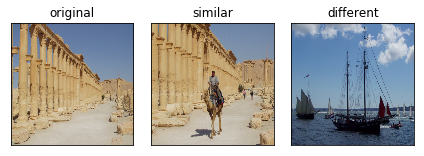

In [5]:
mostrar_imagem(131, os.path.join(IMAGE_DIR, "115200.jpg"), "original")
mostrar_imagem(132, os.path.join(IMAGE_DIR, "115201.jpg"), "similar")
mostrar_imagem(133, os.path.join(IMAGE_DIR, "123700.jpg"), "different")
plt.tight_layout()
plt.show()

In [17]:
def criar_triplas(image_dir):
    img_groups = {}
    for img_file in os.listdir(image_dir):
        prefix, suffix = img_file.split(".")
        gid, pid = prefix[0:4], prefix[4:]
        if gid in img_groups :
            img_groups[gid].append(pid)
        else:
            img_groups[gid] = [pid]
    pos_triples, neg_triples = [], []
    # positive pairs are any combination of images in same group
    for key in img_groups.keys():
        triples = [(key + x[0] + ".jpg", key + x[1] + ".jpg", 1) 
                 for x in itertools.combinations(img_groups[key], 2)]
        pos_triples.extend(triples)
    # need equal number of negative examples
    group_names = list(img_groups.keys())
    for i in range(len(pos_triples)):
        g1, g2 = np.random.choice(np.arange(len(group_names)), size=2, replace=False)
        left = imagem_aleatoria(img_groups, group_names, g1)
        right = imagem_aleatoria(img_groups, group_names, g2)
        neg_triples.append((left, right, 0))
    pos_triples.extend(neg_triples)
    shuffle(pos_triples)
    return pos_triples

triplas = criar_triplas(IMAGE_DIR)

print("# triplas de imagens:", len(triplas))
[x for x in triplas[0:5]]


# triplas de imagens: 4144


[('104202.jpg', '104203.jpg', 1),
 ('108104.jpg', '108106.jpg', 1),
 ('100301.jpg', '123900.jpg', 0),
 ('133601.jpg', '145003.jpg', 0),
 ('134702.jpg', '123700.jpg', 0)]

In [41]:
def carregar_imagem(image_name):
    if not image_cache.has_key(image_name):
        image = plt.imread(os.path.join(IMAGE_DIR, image_name)).astype(np.float32)
        image = imresize(image, (224, 224))
        image = np.divide(image, 256)
        image_cache[image_name] = image
    return image_cache[image_name]

def gerar_triplas_em_lote(image_triples, batch_size, shuffle=False):
    while True:
        # loop once per epoch
        if shuffle:
            indices = np.random.permutation(np.arange(len(image_triples)))
        else:
            indices = np.arange(len(image_triples))
        shuffled_triples = [image_triples[ix] for ix in indices]
        num_batches = len(shuffled_triples) // batch_size
        for bid in range(num_batches):
            # loop once per batch
            images_left, images_right, labels = [], [], []
            batch = shuffled_triples[bid * batch_size : (bid + 1) * batch_size]
            for i in range(batch_size):
                lhs, rhs, label = batch[i]
                images_left.append(carregar_imagem(lhs))
                images_right.append(carregar_imagem(rhs))              
                labels.append(label)
            Xlhs = np.array(images_left)
            Xrhs = np.array(images_right)
            Y = np_utils.to_categorical(np.array(labels), num_classes=2)
            yield ([Xlhs, Xrhs], Y)

TAMANHO_LOTE = 64

divisor = int(len(triplas) * 0.7)
dados_treino, dados_teste = triplas[0:divisor], triplas[divisor:]

### Modelo da Rede

In [29]:
def calcular_distancia(vecs, normalizar=False):
    x, y = vecs
    if normalizar:
        x = K.l2_normalize(x, axis=0)
        y = K.l2_normalize(x, axis=0)
    return K.prod(K.stack([x, y], axis=1), axis=1)

def formato_saida_distancia(shapes):
    return shapes[0]

def computar_precisao(predicoes, rotulos):
    return rotulos[predicoes.ravel() < 0.5].mean()


In [25]:
def criar_instancia_rede_neural(entrada):
    seq = Sequential()
    
    # CONV => RELU => POOL
    seq.add(Conv2D(20, kernel_size=5, padding="same", input_shape=entrada))
    seq.add(Activation("relu"))
    seq.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # CONV => RELU => POOL
    seq.add(Conv2D(50, kernel_size=5, padding="same"))
    seq.add(Activation("relu"))
    seq.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Flatten => RELU
    seq.add(Flatten())
    seq.add(Dense(500))
    
    return seq

### Processando as imagens

In [33]:
formato_entrada = (224, 224, 3)
rede_neural = criar_instancia_rede_neural(formato_entrada)

imagem_esquerda = Input(shape=formato_entrada)
imagem_direita  = Input(shape=formato_entrada)

vetor_saida_esquerda = rede_neural(imagem_esquerda)
vetor_saida_direita  = rede_neural(imagem_direita)

distancia = Lambda(calcular_distancia, 
                  output_shape=formato_saida_distancia)([vetor_saida_esquerda, vetor_saida_direita])

### Unindo os vetores e computando similaridade

In [37]:
fc1 = Dense(128, kernel_initializer="glorot_uniform")(distancia)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc1)
pred = Activation("softmax")(pred)
model = Model(inputs=[imagem_esquerda, imagem_direita], outputs=pred)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
input_12 (InputLayer)            (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
sequential_6 (Sequential)        (None, 500)           78427070    input_11[0][0]                   
                                                                   input_12[0][0]                   
____________________________________________________________________________________________________
lambda_3 (Lambda)                (None, 500)           0           sequential_6[1][0]      

In [38]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [42]:
NUM_EPOCAS = 10

image_cache = {}
lote_de_treinamento = gerar_triplas_em_lote(dados_treino, TAMANHO_LOTE, shuffle=True)
lote_de_validacao = gerar_triplas_em_lote(dados_teste, TAMANHO_LOTE, shuffle=False)

num_passos_treinamento = len(dados_treino) // NUM_EPOCAS
num_passos_validacao = len(dados_teste) // NUM_EPOCAS

historico = model.fit_generator(lote_de_treinamento,
                              steps_per_epoch=num_passos_treinamento,
                              epochs=NUM_EPOCAS,
                              validation_data=lote_de_validacao,
                              validation_steps=num_passos_validacao)

Epoch 1/10


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/Users/ramonfsilva/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/ramonfsilva/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ramonfsilva/anaconda3/lib/python3.6/site-packages/keras/utils/data_utils.py", line 560, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-41-7d9f4d5eb672>", line 24, in gerar_triplas_em_lote
    images_left.append(carregar_imagem(lhs))
  File "<ipython-input-41-7d9f4d5eb672>", line 2, in carregar_imagem
    if not image_cache.has_key(image_name):
AttributeError: 'dict' object has no attribute 'has_key'



StopIteration: 